In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import (ball)
from quantimpy import morphology as mp
from quantimpy import minkowski as mk
from dataclasses import dataclass, field
from ripser import Rips
from persim import plot_diagrams

import cv2 as cv
import os
import argparse
import math
import time
import zlib
import base64
import io 
import datetime
import csv

from tkinter import *
from tkinter import Label, Tk, Button,ttk
from PIL import ImageTk,Image

from joblib import Parallel, delayed
import pandas as pd
import random
import warnings
import random

import openpnm as op

import porespy as ps

class RockData(object):
    def __init__(self, id, path, path_mask,list2,img_num,level_num,level_map):
        self.id = id
        self.path = path
        self.path_mask = path_mask
        self.list2 = list2
        self.img_num = img_num
        self.level_num = level_num
        self.level_map = level_map

    def level_update(self,level_num,level_map):
        self.level_num = level_num
        self.level_map = level_map 

class RockGraf(object):
    def __init__(self, id, volume, surface, curvature, euler, dist):
        self.id = id
        self.volume = volume
        self.surface = surface
        self.curvature = curvature
        self.euler = euler
        self.dist = dist

img = cv.imread('/home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 40/Stone_40_rec00001848.tif', cv.IMREAD_GRAYSCALE)

ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

mask_out_void = np.zeros([th2.shape[0],th2.shape[1]], dtype=int)

#заполненние вертикальных линий

for i in range(mask_out_void.shape[0]):
    j = 0
    while th2[i,j] == 0 and j < th2.shape[1]-1:
        mask_out_void[i,j] = 1
        j += 1

for i in range(mask_out_void.shape[0]):
    j = th2.shape[1]-1
    if mask_out_void[i,j] != 1:
        while th2[i,j] == 0 and j > 0:
            mask_out_void[i,j] = 1
            j -= 1

wave_point = np.array([0,0])
wave_step = 0

for i in range(1,mask_out_void.shape[0]-2):
    for j in range(1,mask_out_void.shape[1]-2):
        if mask_out_void[i,j] == 0:
            if mask_out_void[i-1,j] + mask_out_void[i+1,j] + mask_out_void[i,j-1] + mask_out_void[i,j+1] > 0:
                wave_point = np.concatenate((wave_point, [i,j]))
                wave_step = wave_step + 1

wave = 0
while wave < wave_step:
    x = wave_point[wave*2]
    y = wave_point[wave*2+1]
    if th2[x, y] == 0 and mask_out_void[x,y] != 1:
        wave_point = np.concatenate((wave_point, [x-1,y]))
        wave_point = np.concatenate((wave_point, [x+1,y]))
        wave_point = np.concatenate((wave_point, [x,y-1]))
        wave_point = np.concatenate((wave_point, [x,y+1]))
        wave_step += 4
        mask_out_void[x,y] = 1
    wave += 1

th_with_out_void = cv.bitwise_not(th2)/255 - mask_out_void

minkowski = mk.functionals(np.ndarray.astype(th2, dtype=bool))

grey_pixel = np.zeros([256], dtype = int)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        grey_pixel[img[i,j]] += 1

ps.visualization.set_mpl_style()

im = np.ndarray.astype(th_with_out_void, dtype=bool)
snow = ps.filters.snow_partitioning(im=im)
regions = snow.regions*snow.im

props = ps.metrics.regionprops_3D(regions)

df = ps.metrics.props_to_DataFrame(props)

sum = 0
mid_bbox_volume = 0
mid_sphericity = 0
mid_surface_area = 0
mid_convex_volume = 0
mid_num_pixels = 0
mid_area = 0
mid_area_bbox = 0
mid_area_convex = 0
mid_eccentricity = 0
mid_equivalent_diameter_area = 0
mid_euler_number = 0
mid_extent = 0
mid_feret_diameter_max = 0
mid_area_filled = 0
mid_axis_major_length = 0
mid_axis_minor_length = 0
mid_orientation = 0
mid_perimeter = 0
mid_perimeter_crofton = 0
mid_solidity = 0

sum_voluem = np.sum(th_with_out_void)

for i in range(df.shape[0]):
    sum += df.iloc[i,1]
    mid_bbox_volume += df.iloc[i,2] * df.iloc[i,1]/sum_voluem
    mid_sphericity += df.iloc[i,3] * df.iloc[i,1]/sum_voluem
    mid_surface_area += df.iloc[i,4] * df.iloc[i,1]/sum_voluem
    mid_convex_volume += df.iloc[i,5] * df.iloc[i,1]/sum_voluem
    mid_num_pixels += df.iloc[i,6] * df.iloc[i,1]/sum_voluem
    mid_area += df.iloc[i,7] * df.iloc[i,1]/sum_voluem
    mid_area_bbox += df.iloc[i,8] * df.iloc[i,1]/sum_voluem
    mid_area_convex += df.iloc[i,9] * df.iloc[i,1]/sum_voluem
    mid_eccentricity += df.iloc[i,10] * df.iloc[i,1]/sum_voluem
    mid_equivalent_diameter_area += df.iloc[i,11] * df.iloc[i,1]/sum_voluem
    mid_euler_number += df.iloc[i,12] * df.iloc[i,1]/sum_voluem
    mid_extent += df.iloc[i,13] * df.iloc[i,1]/sum_voluem
    mid_feret_diameter_max += df.iloc[i,14] * df.iloc[i,1]/sum_voluem
    mid_area_filled += df.iloc[i,15] * df.iloc[i,1]/sum_voluem
    mid_axis_major_length += df.iloc[i,16] * df.iloc[i,1]/sum_voluem
    mid_axis_minor_length += df.iloc[i,17] * df.iloc[i,1]/sum_voluem
    mid_orientation += df.iloc[i,18] * df.iloc[i,1]/sum_voluem
    mid_perimeter += df.iloc[i,19] * df.iloc[i,1]/sum_voluem
    mid_perimeter_crofton += df.iloc[i,20] * df.iloc[i,1]/sum_voluem
    mid_solidity += df.iloc[i,21] * df.iloc[i,1]/sum_voluem

print("Площадь: " + str(minkowski[0]))
print("Сферичность: " + str(minkowski[1]))
print("Характеристика Эйлера: " + str(minkowski[2]))
print("Пористость: " + str(np.sum(th_with_out_void)/ (mask_out_void.shape[0] * mask_out_void.shape[1] - np.sum(mask_out_void))))
print("Средние показатели пор.")
print("mid_bbox_volume:                 " + str(mid_bbox_volume))
print("mid_sphericity:                  " + str(mid_sphericity))
print("mid_surface_area:                " + str(mid_surface_area))
print("mid_convex_volume:               " + str(mid_convex_volume))
print("mid_num_pixels:                  " + str(mid_num_pixels))
print("mid_area:                        " + str(mid_area))
print("mid_area_bbox:                   " + str(mid_area_bbox))
print("mid_area_convex:                 " + str(mid_area_convex))
print("mid_eccentricity:                " + str(mid_eccentricity))
print("mid_equivalent_diameter_area:    " + str(mid_equivalent_diameter_area))
print("mid_euler_number:                " + str(mid_euler_number))
print("mid_extent:                      " + str(mid_extent))
print("mid_feret_diameter_max:          " + str(mid_feret_diameter_max))
print("mid_area_filled:                 " + str(mid_area_filled))
print("mid_axis_major_length:           " + str(mid_axis_major_length))
print("mid_axis_minor_length:           " + str(mid_axis_minor_length))
print("mid_orientation:                 " + str(mid_orientation))
print("mid_perimeter:                   " + str(mid_perimeter))
print("mid_perimeter_crofton:           " + str(mid_perimeter_crofton))
print("mid_solidity:                    " + str(mid_solidity))
print("Распределение серости.")
for i in range(len(grey_pixel)):
    print(str(i) + ": " + str(grey_pixel[i]))

In [2]:
import openpnm as op

import porespy as ps

def img_charasteristik(img):
    res = np.zeros([300], dtype = float)

    ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    mask_out_void = np.zeros([th2.shape[0],th2.shape[1]], dtype=int)

    #заполненние вертикальных линий

    for i in range(mask_out_void.shape[0]):
        j = 0
        while th2[i,j] == 0 and j < th2.shape[1]-1:
            mask_out_void[i,j] = 1
            j += 1

    for i in range(mask_out_void.shape[0]):
        j = th2.shape[1]-1
        if mask_out_void[i,j] != 1:
            while th2[i,j] == 0 and j > 0:
                mask_out_void[i,j] = 1
                j -= 1

    wave_point = np.array([0,0])
    wave_step = 0

    for i in range(1,mask_out_void.shape[0]-2):
        for j in range(1,mask_out_void.shape[1]-2):
            if mask_out_void[i,j] == 0:
                if mask_out_void[i-1,j] + mask_out_void[i+1,j] + mask_out_void[i,j-1] + mask_out_void[i,j+1] > 0:
                    wave_point = np.concatenate((wave_point, [i,j]))
                    wave_step = wave_step + 1

    wave = 0
    while wave < wave_step:
        x = wave_point[wave*2]
        y = wave_point[wave*2+1]
        if th2[x, y] == 0 and mask_out_void[x,y] != 1:
            wave_point = np.concatenate((wave_point, [x-1,y]))
            wave_point = np.concatenate((wave_point, [x+1,y]))
            wave_point = np.concatenate((wave_point, [x,y-1]))
            wave_point = np.concatenate((wave_point, [x,y+1]))
            wave_step += 4
            mask_out_void[x,y] = 1
        wave += 1

    th_with_out_void = cv.bitwise_not(th2)/255 - mask_out_void

    minkowski = mk.functionals(np.ndarray.astype(th2, dtype=bool))

    grey_pixel = np.zeros([256], dtype = int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            grey_pixel[img[i,j]] += 1

    ps.visualization.set_mpl_style()

    im = np.ndarray.astype(th_with_out_void, dtype=bool)

    for i in range(10):
        for j in range(10):
            im[i,j] = 1

    snow = ps.filters.snow_partitioning(im=im)
    regions = snow.regions*snow.im

    props = ps.metrics.regionprops_3D(regions)

    df = ps.metrics.props_to_DataFrame(props)

    sum_voluem = np.sum(th_with_out_void)

    n = 0

    res[n] = minkowski[0]
    n += 1
    res[n] = minkowski[1]
    n += 1
    res[n] = minkowski[2]
    n += 1
    res[n] = np.sum(th_with_out_void)/ (mask_out_void.shape[0] * mask_out_void.shape[1] - np.sum(mask_out_void))
    n += 1
    for i in range(2,df.shape[1]):
        for j in range(df.shape[0]):
            res[n] += df.iloc[j,i] * df.iloc[j,1]/sum_voluem
        n += 1
    for i in range(len(grey_pixel)):
        res[n] = grey_pixel[i]
        n += 1

    # for i in range(len(res)):
    #     print(res[i])

    return res


id =  20
Image count =  1911


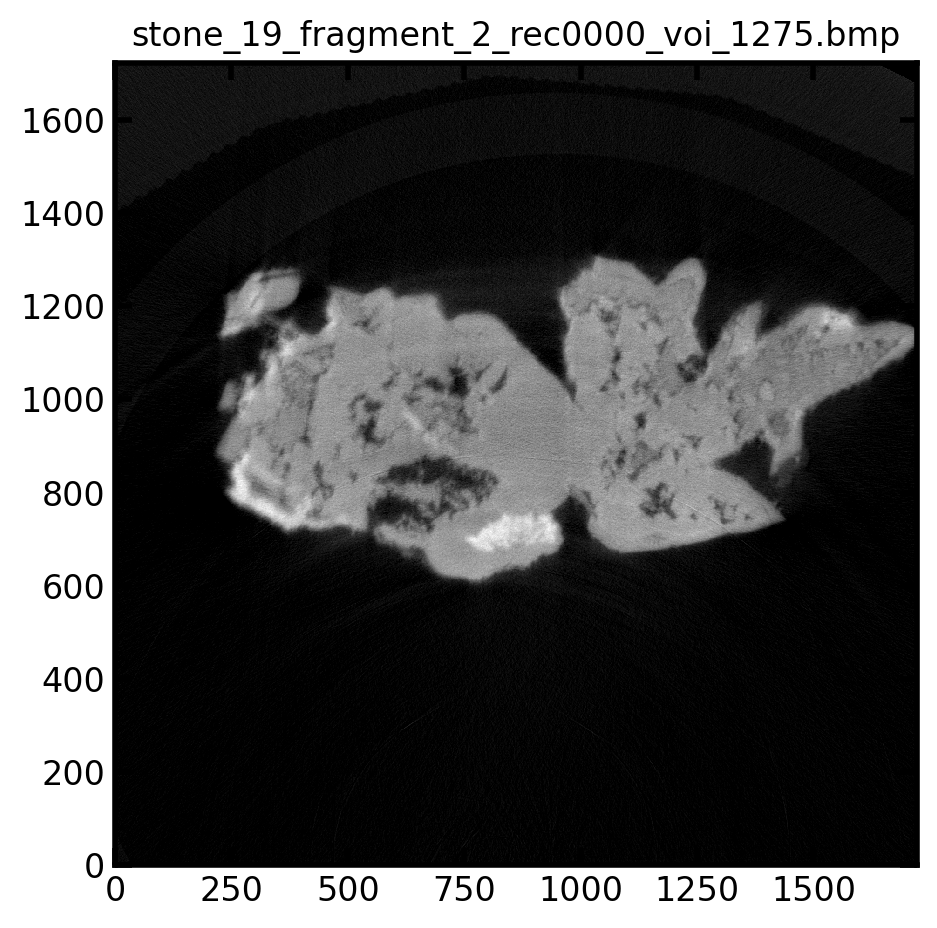

id =  33
Image count =  1912


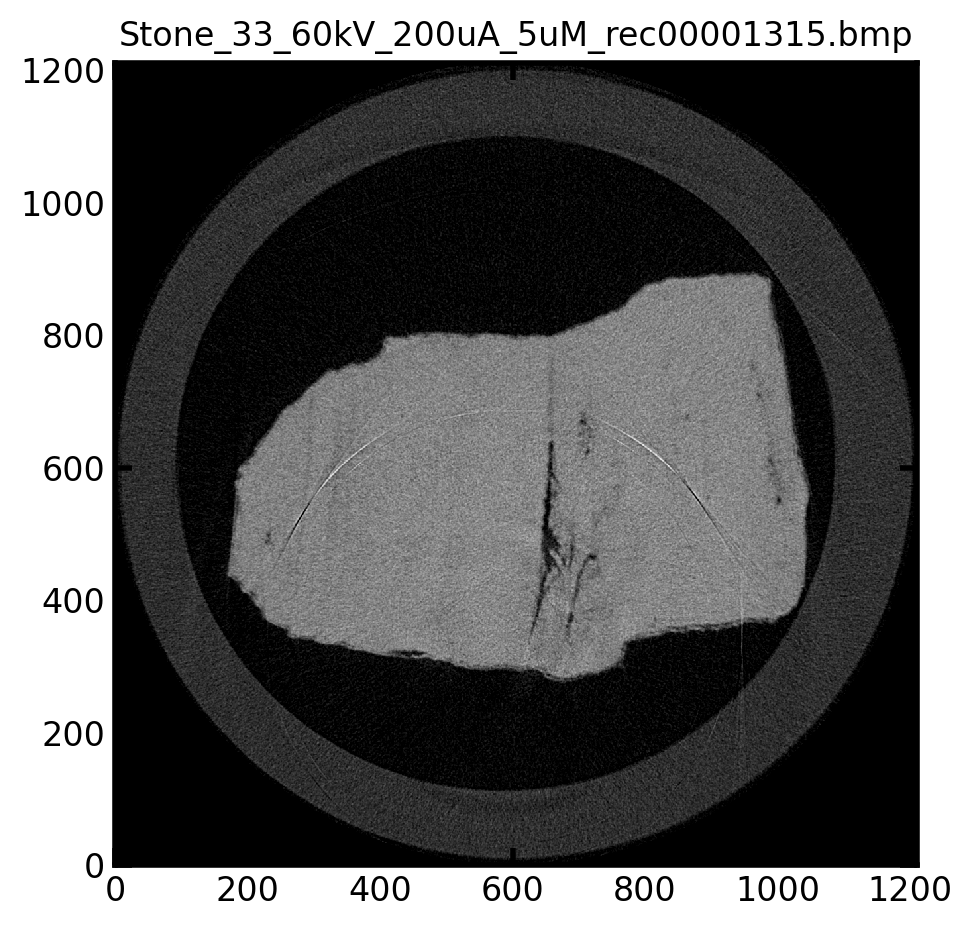

id =  35
Image count =  2368


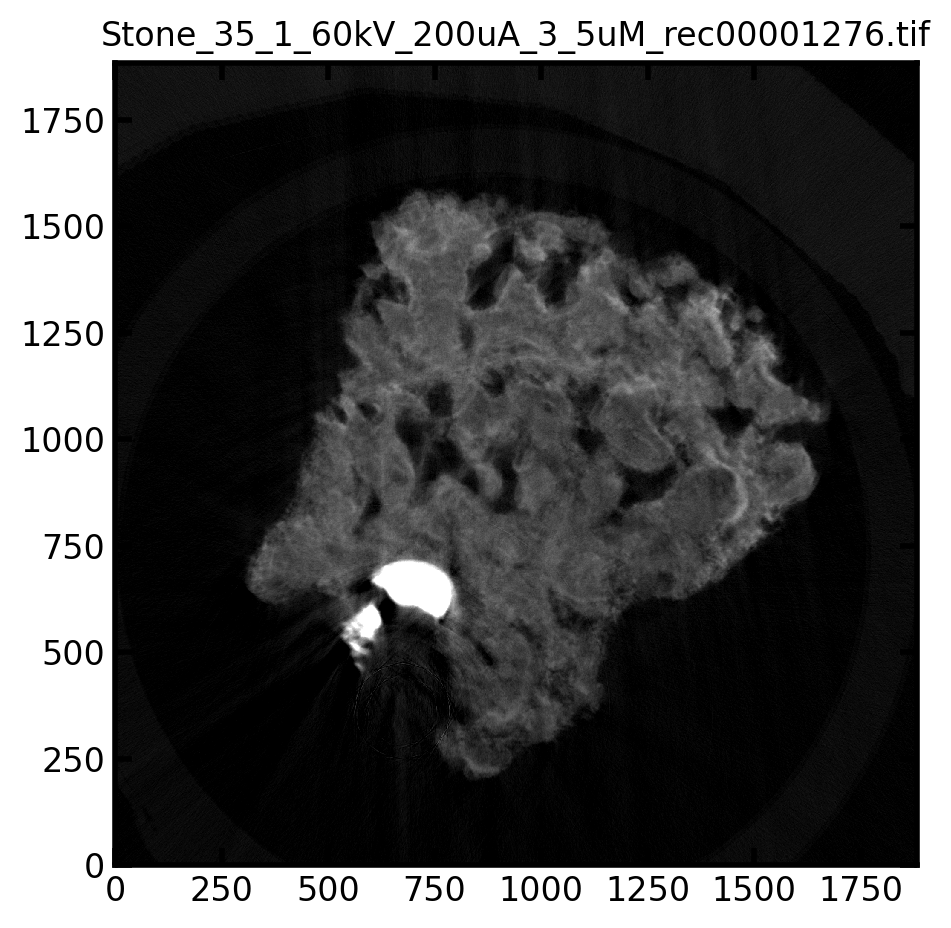

id =  1001
Image count =  2244


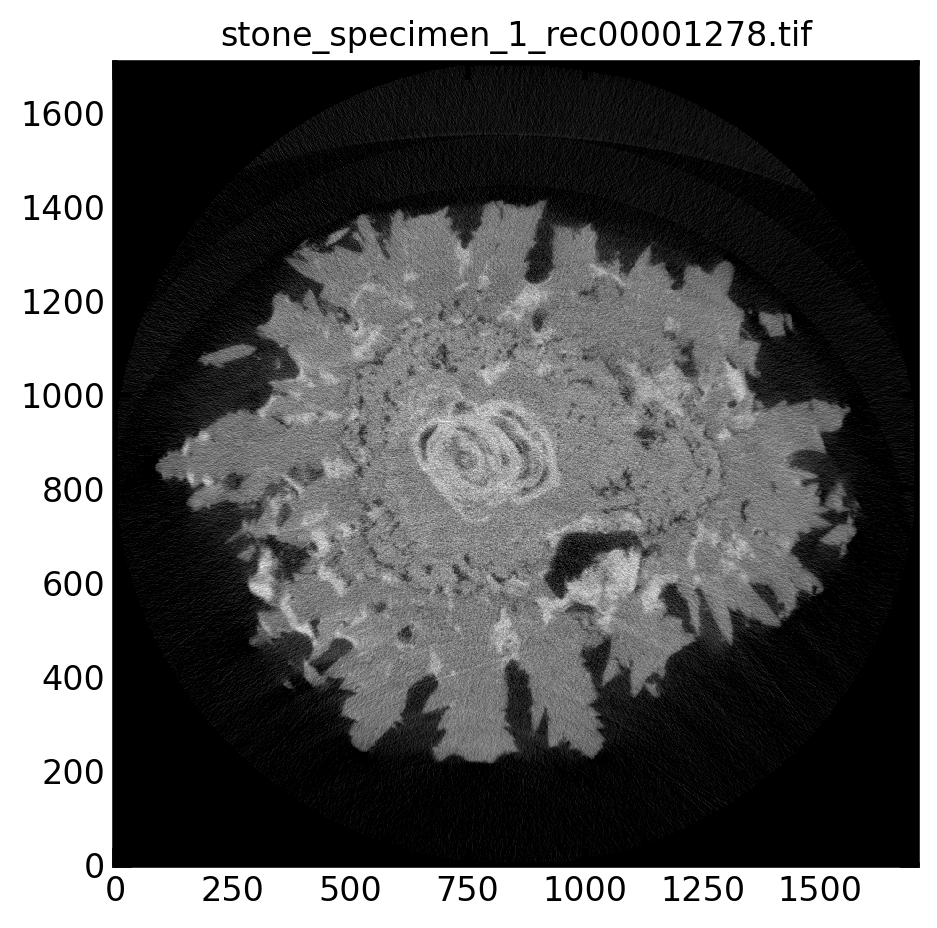

id =  10009
Image count =  2432


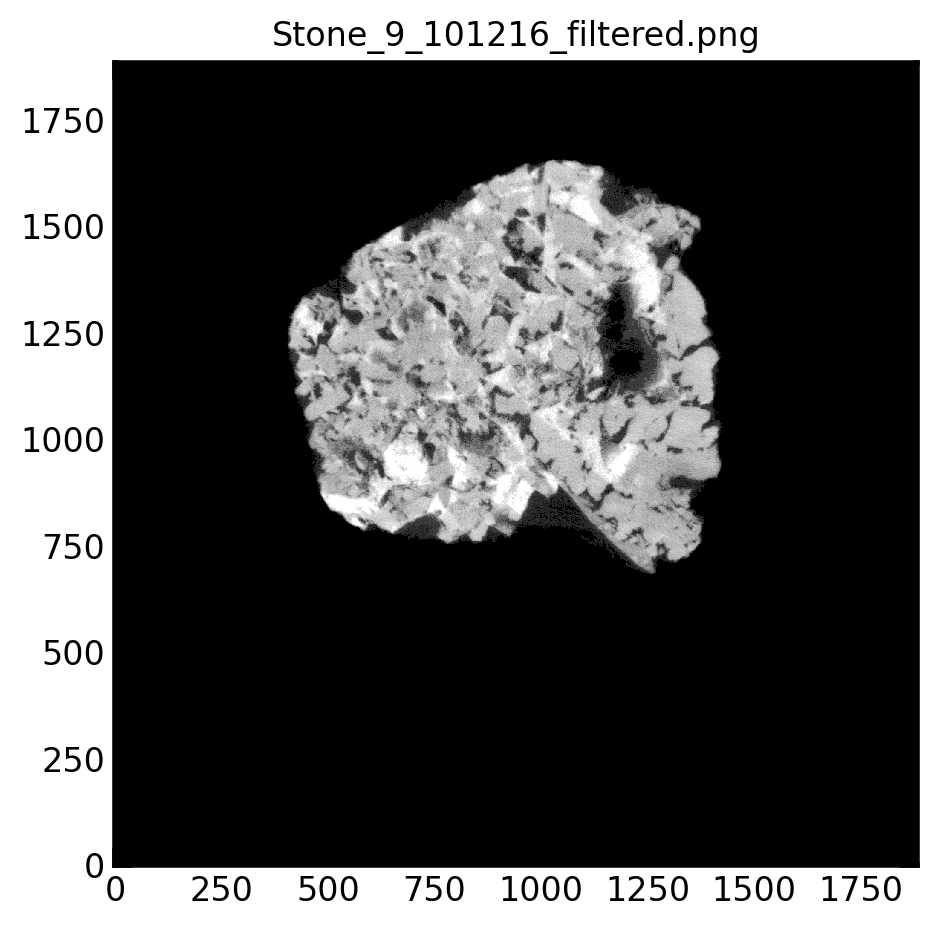

id =  10020
Image count =  1911


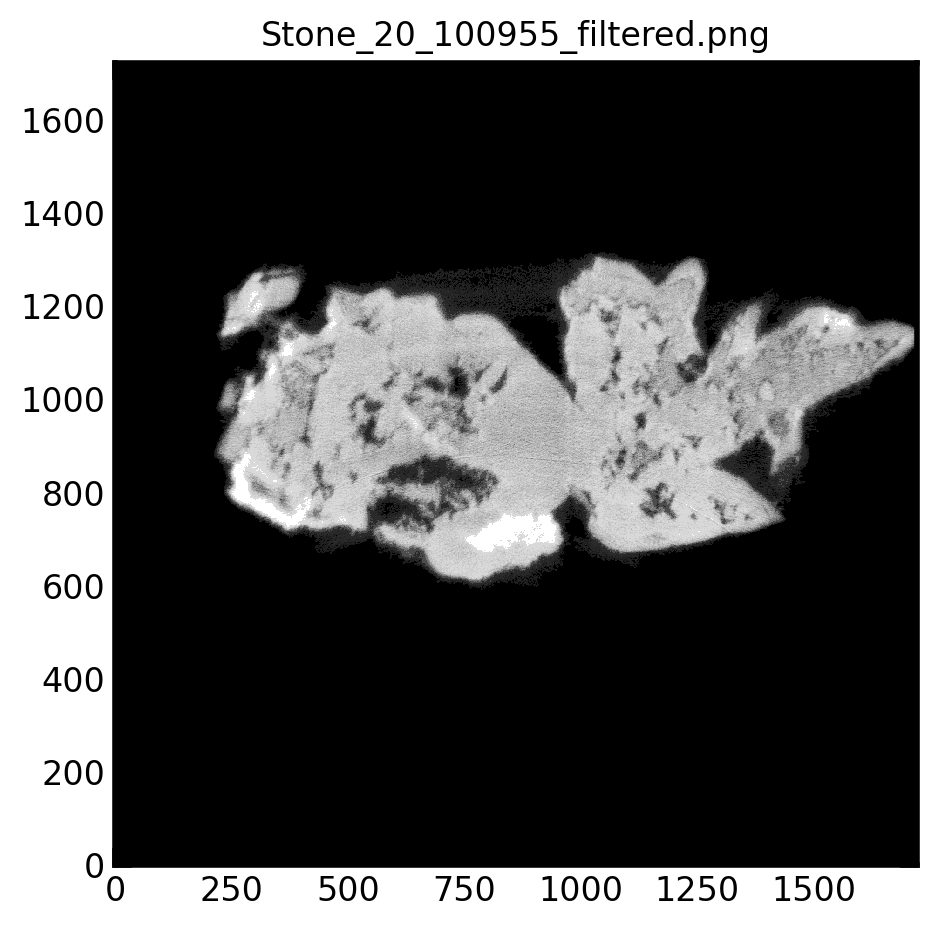

id =  10035
Image count =  2368


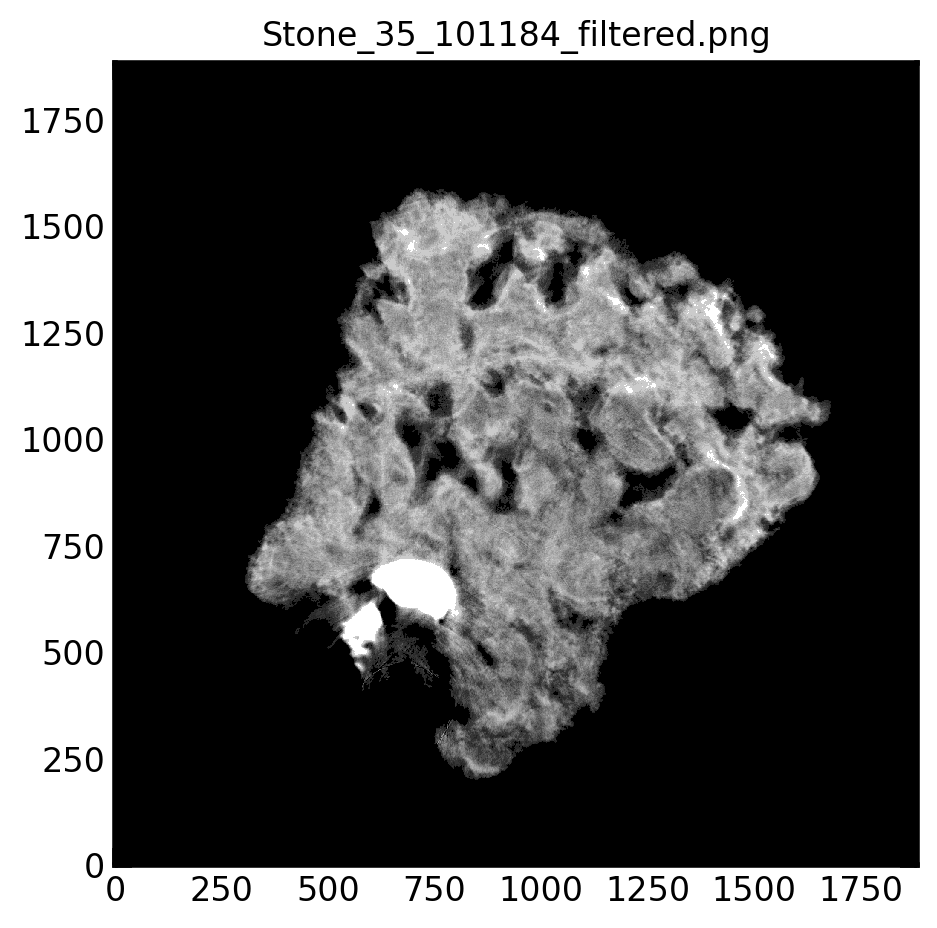

id =  11001
Image count =  2244


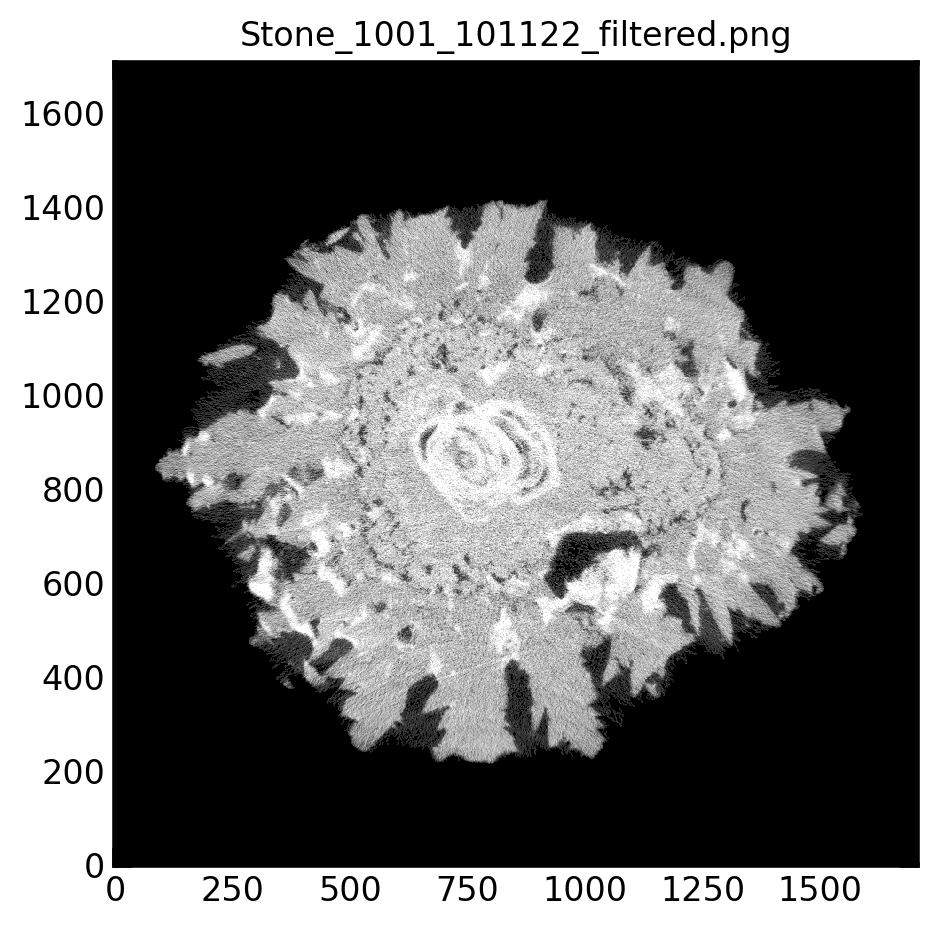

In [3]:
 #Выбор камней

id_rock = [20, 33, 35, 1001, 10009, 10020, 10035, 11001]
          #0  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26   27   28    29    30
#2, 9, 10, 11, 12, 13. 16, 18, 19, 20, 25, 27, 28, 30, 31, 32, 33. 34, 35, 36. 37, 40, 43, 50, 51, 52, 82, 153. 155. 1001. 1002
#2, 9, 10, 11, 12, 13, 16, 18, 19, 20, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 43, 50, 51, 52, 82, 153, 155, 1001, 1002
#id = 2     /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Uric acid/Pure uric acid/Stone 2/
#id = 9     /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 9/
#id = 10    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 10/
#id = 11    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 11/
#id = 12    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 12/
#id = 13    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Uric acid/Pure uric acid/Stone 13/
#id = 16    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 16/
#id = 18    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 18/
#id = 19    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 19_1/
#id = 20    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 19_2/
#id = 25    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 25/
#id = 27    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 27/
#id = 28    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Uric acid/Uric acid with calcium/Stone 28/
#id = 30    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 30/
#id = 31    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 31/
#id = 32    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Uric acid/Uric acid with calcium/Stone 32/
#id = 33    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Uric acid/Pure uric acid/Stone 33/
#id = 34    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 34/
#id = 35    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 35/
#id = 36    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Cystine/Stone 36/
#id = 37    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 37/
#id = 40    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 40/
#id = 43    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 43/
#id = 50    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 50/
#id = 51    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 51/
#id = 52    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/Stone 52/
#id = 82    /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Unclass/Stone 82/
#id = 153   /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Cystine/Stone 153/
#id = 155   /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Uric acid/Uric acid with calcium/Stone 155/
#id = 1001  /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Calcium/N1/
#id = 1002  /home/pc-burevestnik/PochRock_v2/Rock_Base_1/Uric acid/Uric acid with calcium/Stone N2/

#10002, 10009, 10010, 10011, 10012, 10013, 10016, 10018, 10019, 10020, 10025, 10027, 10028, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10040, 10043, 10050, 10051, 10052, 10082, 10153, 10155, 11001, 11002
#id = 10002     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Uric acid/Pure uric acid/Stone 2/
#id = 10009     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 9/
#id = 10010     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 10/
#id = 10011     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 11/
#id = 10012     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 12/
#id = 10013     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Uric acid/Pure uric acid/Stone 13/
#id = 10016     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 16/
#id = 10018     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 18/
#id = 10019     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 19_1/
#id = 10020     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 19_2/
#id = 10025     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 25/
#id = 10027     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 27/
#id = 10028     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Uric acid/Uric acid with calcium/Stone 28/
#id = 10030     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 30/
#id = 10031     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 31/
#id = 10032     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Uric acid/Uric acid with calcium/Stone 32/
#id = 10033     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Uric acid/Pure uric acid/Stone 33/
#id = 10034     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 34/
#id = 10035     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 35/
#id = 10036     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Cystine/Stone 36/
#id = 10037     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 37/
#id = 10040     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 40/
#id = 10043     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 43/
#id = 10050     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 50/
#id = 10051     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 51/
#id = 10052     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/Stone 52/
#id = 10082     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Unclass/Stone 82/
#id = 10153     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Cystine/Stone 153/
#id = 10155     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Uric acid/Uric acid with calcium/Stone 155,
#id = 11001     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Calcium/N1/
#id = 11002     /home/pc-burevestnik/PochRock_v2/Rock_Base_2/Uric acid/Uric acid with calcium/Stone N2/

#Созданние массива информации о камнях

#Data_about_rocks_p = RockData(0, '0', '0', [0], 0, 0, [0]) 

#Data_about_rocks = RockList(np.zeros(len(id_rock),dtype=RockData))

my_Rocks = []

for i in range(len(id_rock)):
    #Составление списков изображений

    if id_rock[i] == 2:
        file_name = 'Rock_Base_1/Uric acid/Pure uric acid/Stone 2/'
    if id_rock[i] == 9:
        file_name = 'Rock_Base_1/Calcium/Stone 9/'
    if id_rock[i] == 10:
        file_name = 'Rock_Base_1/Calcium/Stone 10/'
    if id_rock[i] == 11:
        file_name = 'Rock_Base_1/Unclass/Stone 11/'
    if id_rock[i] == 12:
        file_name = 'Rock_Base_1/Unclass/Stone 12/'
    if id_rock[i] == 13:
        file_name = 'Rock_Base_1/Uric acid/Pure uric acid/Stone 13/' 
    if id_rock[i] == 16:
        file_name = 'Rock_Base_1/Calcium/Stone 16/'
    if id_rock[i] == 18:
        file_name = 'Rock_Base_1/Calcium/Stone 18/'
    if id_rock[i] == 19:
        file_name = 'Rock_Base_1/Unclass/Stone 19_1/'
    if id_rock[i] == 20:
        file_name = 'Rock_Base_1/Unclass/Stone 19_2/'
    if id_rock[i] == 25:
        file_name = 'Rock_Base_1/Calcium/Stone 25/'
    if id_rock[i] == 27:
        file_name = 'Rock_Base_1/Unclass/Stone 27/'
    if id_rock[i] == 28:
        file_name = 'Rock_Base_1/Uric acid/Uric acid with calcium/Stone 28/'
    if id_rock[i] == 30:
        file_name = 'Rock_Base_1/Calcium/Stone 30/'
    if id_rock[i] == 31:
        file_name = 'Rock_Base_1/Calcium/Stone 31/'
    if id_rock[i] == 32:
        file_name = 'Rock_Base_1/Uric acid/Uric acid with calcium/Stone 32/'
    if id_rock[i] == 33:
        file_name = 'Rock_Base_1/Uric acid/Pure uric acid/Stone 33/'
    if id_rock[i] == 34:
        file_name = 'Rock_Base_1/Calcium/Stone 34/'
    if id_rock[i] == 35:
        file_name = 'Rock_Base_1/Unclass/Stone 35/'
    if id_rock[i] == 36:
        file_name = 'Rock_Base_1/Cystine/Stone 36/'
    if id_rock[i] == 37:
        file_name = 'Rock_Base_1/Unclass/Stone 37/'
    if id_rock[i] == 40:
        file_name = 'Rock_Base_1/Unclass/Stone 40/'
    if id_rock[i] == 43:
        file_name = 'Rock_Base_1/Calcium/Stone 43/'
    if id_rock[i] == 50:
        file_name = 'Rock_Base_1/Calcium/Stone 50/'
    if id_rock[i] == 51:
        file_name = 'Rock_Base_1/Unclass/Stone 51/'
    if id_rock[i] == 52:
        file_name = 'Rock_Base_1/Calcium/Stone 52/'
    if id_rock[i] == 82:
        file_name = 'Rock_Base_1/Unclass/Stone 82/'
    if id_rock[i] == 153:
        file_name = 'Rock_Base_1/Cystine/Stone 153/'
    if id_rock[i] == 155:
        file_name = 'Rock_Base_1/Uric acid/Uric acid with calcium/Stone 155/'
    if id_rock[i] == 1001:
        file_name = 'Rock_Base_1/Calcium/Stone N1/'
    if id_rock[i] == 1002:
        file_name = 'Rock_Base_1/Uric acid/Uric acid with calcium/Stone N2/'

    if id_rock[i] == 10002:
        file_name = 'Rock_Base_2/Uric acid/Pure uric acid/Stone 2/'
    if id_rock[i] == 10009:
        file_name = 'Rock_Base_2/Calcium/Stone 9/'
    if id_rock[i] == 10010:
        file_name = 'Rock_Base_2/Calcium/Stone 10/'
    if id_rock[i] == 10011:
        file_name = 'Rock_Base_2/Unclass/Stone 11/'
    if id_rock[i] == 10012:
        file_name = 'Rock_Base_2/Unclass/Stone 12/'
    if id_rock[i] == 10013:
        file_name = 'Rock_Base_2/Uric acid/Pure uric acid/Stone 13/' 
    if id_rock[i] == 10016:
        file_name = 'Rock_Base_2/Calcium/Stone 16/'
    if id_rock[i] == 10018:
        file_name = 'Rock_Base_2/Calcium/Stone 18/'
    if id_rock[i] == 10019:
        file_name = 'Rock_Base_2/Unclass/Stone 19_1/'
    if id_rock[i] == 10020:
        file_name = 'Rock_Base_2/Unclass/Stone 19_2/'
    if id_rock[i] == 10025:
        file_name = 'Rock_Base_2/Calcium/Stone 25/'
    if id_rock[i] == 10027:
        file_name = 'Rock_Base_2/Unclass/Stone 27/'
    if id_rock[i] == 10028:
        file_name = 'Rock_Base_2/Uric acid/Uric acid with calcium/Stone 28/'
    if id_rock[i] == 10030:
        file_name = 'Rock_Base_2/Calcium/Stone 30/'
    if id_rock[i] == 10031:
        file_name = 'Rock_Base_2/Calcium/Stone 31/'
    if id_rock[i] == 10032:
        file_name = 'Rock_Base_2/Uric acid/Uric acid with calcium/Stone 32/'
    if id_rock[i] == 10033:
        file_name = 'Rock_Base_2/Uric acid/Pure uric acid/Stone 33/'
    if id_rock[i] == 10034:
        file_name = 'Rock_Base_2/Calcium/Stone 34/'
    if id_rock[i] == 10035:
        file_name = 'Rock_Base_2/Unclass/Stone 35/'
    if id_rock[i] == 10036:
        file_name = 'Rock_Base_2/Cystine/Stone 36/'
    if id_rock[i] == 10037:
        file_name = 'Rock_Base_2/Unclass/Stone 37/'
    if id_rock[i] == 10040:
        file_name = 'Rock_Base_2/Unclass/Stone 40/'
    if id_rock[i] == 10043:
        file_name = 'Rock_Base_2/Calcium/Stone 43/'
    if id_rock[i] == 10050:
        file_name = 'Rock_Base_2/Calcium/Stone 50/'
    if id_rock[i] == 10051:
        file_name = 'Rock_Base_2/Unclass/Stone 51/'
    if id_rock[i] == 10052:
        file_name = 'Rock_Base_2/Calcium/Stone 52/'
    if id_rock[i] == 10082:
        file_name = 'Rock_Base_2/Unclass/Stone 82/'
    if id_rock[i] == 10153:
        file_name = 'Rock_Base_2/Cystine/Stone 153/'
    if id_rock[i] == 10155:
        file_name = 'Rock_Base_2/Uric acid/Uric acid with calcium/Stone 155/'
    if id_rock[i] == 11001:
        file_name = 'Rock_Base_2/Calcium/Stone N1/'
    if id_rock[i] == 11002:
        file_name = 'Rock_Base_2/Uric acid/Uric acid with calcium/Stone N2/'

    id = id_rock[i]
    path = '/home/pc-burevestnik/PochRock_v2/' + file_name

    myList = os.listdir(path)
    list2 = []
    for _, imgs in enumerate(myList):
        img_name = imgs.split(".")
        #print(img_name)
        if len(img_name) > 1:
            if id < 10000:
                if img_name[1] == "tif" or img_name[1] == "bmp":
                    list2.append(imgs)
            else:
                if img_name[1] == "png":
                    list2.append(imgs)


    list2.sort()
    #print(list2)

    #Data_about_rocks_p.list2 = list2
    img_num = len(list2)

    print('id = ', id_rock[i])
    print('Image count = ',len(list2))

    #вывод изображения

    #img= cv.imread(os.path.join(path,imgs),0)
    img = cv.imread(os.path.join(path,list2[int(len(list2)/2)]),0)

    # max = 0
    # for j in range(img.shape[0]):
    #     for k in range(img.shape[1]):
    #         if max < img[j,k]:
    #             max = img[j,k]

    #print(max)

    plt.gray()
    plt.title(list2[int(len(list2)/2)])
    plt.imshow(img[:,:])
    plt.show()

    #Data_about_rocks.Rocks[i].id = Data_about_rocks_p.id

    my_Rocks.append(RockData(id, path, path,list2,img_num,0,['0']))

    #print(my_Rocks[0].id)

In [4]:
import csv

def calc_pore(my_Rocks):
    w_file = open("analisys_pore_data_"+str(my_Rocks.id)+".csv", 'w')
    for i in range(int(3/10*len(my_Rocks.list2)),int(7/10*len(my_Rocks.list2))):
        #print(i)
        img = cv.imread(os.path.join(my_Rocks.path,my_Rocks.list2[i]),0)
        res = img_charasteristik(img)
        #print(res)
        for j in range(len(res)):
            w_file.write(str(res[j]))
            w_file.write(";")
        w_file.write("\n")
    w_file.close()
        

In [ ]:
print(len(my_Rocks))

In [ ]:
for i in range(len(my_Rocks)):
    calc_pore(my_Rocks[i])

In [ ]:
res = Parallel(n_jobs=20)(delayed(calc_pore)(my_Rocks[i]) for i in range(1,len(my_Rocks)))